<a id='home'></a>
### purpose

See if I can recapitulate the agreement between common garden perfomance and genetic offset, here using climate, and geographic distance instead of offset from eg gradient forests

### outline

[1. target climate vars](#target)

- the climate variables I used will affect the magnitude of the climate distance calculated
- I will use a combination of:
    1. all climate vars
    2. those climate vars used by British Columbia's climate-based seed transfer ('MAT', 'MCMT', 'TD', 'MAP', 'MSP', 'DD5', 'EMT')
    3. those climate vars shown to explain significant variation in the common garden trials of these species
        The climate variables for the transfer function used to best predict lodgepole pine height was MAT (>64% var exp) and ln(AHM)  (> 6%).
        
            Wang T, Hanann A, Yanchuk A, O’Neill GA, Aitken SN. 2006. Use of response functions in selecting lodgepole pine populations for future climates. Global Change Biol 12:2404–2416.
 
        For Douglas-fir, it is MAT, SHM, and TD – though MAT alone explained the vast majority of variation (77-92% depending on phenotype)s.
        
            Chakraborty D, Wang T, Andre K, Konnert M, Lexer MJ, Matulla C, Schueler S. 2015. Selecting Populations for Non-Analogous Climate Conditions Using Universal Response Functions: The Case of Douglas-Fir in Central Europe. Plos One 10:e0136357.
        
    4. WZA vars - the subset of climate vars that are being used for convergence paper using WZA ('MAT', 'MCMT', 'MSP', 'PAS', 'SHM', 'Elevation', 'FFP') - except for LAT

[2. read in population data](#read)
- lat/long + phenotypic data

[3. calculate climate and geographic distance](#calc)
- use Mahalanobis distance to calculate climate distance to common garden for each pop using each of the climate sets from (1)
- use Vincenty's geodesic to calculate geographic distance to common garden for each pop

[4. compare distances to phenotypes](#compare)
- plot relationship between phenotype and climate/geographic distance

In [1]:
from pythonimports import *
from scipy import linalg
from vincenty import vincenty
import seaborn as sns

sns.set(rc={'figure.figsize':(8,5)})

t1 = dt.now()

jpphenodir = '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/phenotypes'
dfphenodir = '/data/projects/pool_seq/phenotypic_data/doug-fir'

resdir = makedir('/data/projects/pool_seq/phenotypic_data/offset_misc_files/results/climate_geo_dist')

lview,dview = get_client()

latest_commit()
sinfo(html=True)

56 56
##################################################################
Current commit of pythonimports:
commit 9f2b6d7984dd7a121d365ff406e02c14cafd5560  
Author: Brandon Lind <brandon.lind@ubc.ca>  
Date:   Fri Apr 22 13:34:17 2022 -0600
Today:	April 23, 2022 - 10:16:38
python version: 3.8.5
##################################################################



<a id='target'></a>
# 1. target climate vars
    1. all climate vars
    2. those climate vars used by British Columbia's climate-based seed transfer
    3. those climate vars shown to explain significant variation in the common garden trials of these species
    4. WZA vars - the subset of climate vars that are being used for WZA

In [2]:
# 1. i'll use the tables read in `read in population data` to get full list `envs` 
    # - see end of section before assigning population colors
cvars = {}

In [3]:
# 2. the climate variables used by British Columbia's climate-based seed transfer
cvars['cbst'] = ['MAT', 'MCMT', 'TD', 'MAP', 'MSP', 'DD5', 'EMT']

In [4]:
# 3. climate variables of origin explaining significant variation in provinance trials for each species
cvars['doug_prov'] = ['MAT', 'AHM']
cvars['jack_prov'] = ['MAT', 'SHM', 'TD']

In [5]:
# 4. WZA vars used in convergence paper
cvars['wza'] = ['MAT', 'MCMT', 'MSP', 'PAS', 'SHM', 'LAT', 'Elevation', 'FFP']

<a id='read'></a>
# 2. read in population data

[top](#home)

### jack pine popdata

In [6]:
envdata = {}
envdata['jp'] = pd.read_table('/data/projects/pool_seq/environemental_data/jp_rm_p24/jp_no-p24_raw_env-19variables.txt')
envdata['jp'].index = envdata['jp']['our_id'].tolist()
envdata['jp'].head()

id1  id2   our_id      LAT      LONG  Elevation   AHM  CMD   DD5  \
JP_p98   9150251   38   JP_p98  54.3333 -106.6333        537  21.2  181  1273   
JP_p73      3273   22   JP_p73  44.4200  -84.6800        359  22.0  241  1956   
JP_p97   8060006   37   JP_p97  56.1167 -116.9167        636  23.5  242  1188   
JP_p60      3260   17   JP_p60  46.7200  -84.3900        203  16.5  135  1557   
JP_p100  9040116   40  JP_p100  55.7667  -97.8167        205  13.3  130  1003   

         DD_0   EMT   EXT  Eref  FFP  MAP  MAT  MCMT  MSP  MWMT  NFFD  PAS  \
JP_p98   2217 -46.0  34.7   534  103  461 -0.2 -20.1  305  16.6   149  129   
JP_p73    835 -34.1  36.6   745  131  732  6.1  -8.0  395  19.8   163  140   
JP_p97   2009 -44.3  34.8   556   90  432  0.2 -19.8  272  15.4   138  133   
JP_p60   1116 -36.8  34.3   599  123  848  4.0 -10.7  397  17.6   156  265   
JP_p100  2956 -49.7  35.2   448   82  506 -3.3 -24.9  315  15.7   106  191   

          SHM    TD  bFFP  eFFP group_color  
JP_p98   54.4  36.7   148   251       green  
JP_p73   50.0  27.8   141   271        blue  
JP_p97   56.5  35.1   151   241       green  
JP_p60   44.2  28.3   147   271        blue  
JP_p100  49.9  40.6   163   245       green

### jack pine phenotype

In [7]:
# get the common garden files for jack pine
jpfiles = fs(jpphenodir, 'cg-data_provpops')

phenos = ['Mortality_2018', 'Mean_Height_2018', 'Mean_DBH2018']

jpdata = {}
for f in jpfiles:
    garden = f.split("_")[-1].rstrip('.txt')
    if garden == 'petawawa':
        continue
    if garden == 'st-christine':
        garden = 'christine'  # match name in `cgdata.index`
    jpdata[garden] = pd.read_table(f)
    jpdata[garden].index = jpdata[garden]['our_id'].tolist()
    jpdata[garden] = jpdata[garden][phenos]
    print(garden, nrow(jpdata[garden]))

jpdata[garden].head()

fontbrune 27
christine 28


Mortality_2018  Mean_Height_2018  Mean_DBH2018
JP_p4             70.0           1799.09        228.00
JP_p6             64.0           1856.67        239.60
JP_p8             58.0           1988.95        259.63
JP_p14            72.0           1636.67        211.83
JP_p20            88.0           1578.33        218.50

### doug-fir pop data

In [8]:
# map prov ID to our ID to translate pop names in phenotype data below
envdata['combined'] = pd.read_table('/data/projects/pool_seq/environemental_data/change_p6/df_ALL-naturalpops_raw_env-19variables_change-p6.txt')
envdata['combined'].index = envdata['combined']['our_id'].tolist()
provdict = dict(zip(envdata['combined']['prov'], envdata['combined']['our_id']))
print(provdict)

{1: 'DF_p1', 2: 'DF_p2', 3: 'DF_p3', 4: 'DF_p4', 5: 'DF_p5', 6: 'DF_p6', 7: 'DF_p7', 8: 'DF_p8', 9: 'DF_p9', 10: 'DF_p10', 11: 'DF_p11', 12: 'DF_p12', 13: 'DF_p13', 14: 'DF_p14', 15: 'DF_p15', 16: 'DF_p16', 17: 'DF_p17', 18: 'DF_p18', 19: 'DF_p19', 20: 'DF_p20', 23: 'DF_p23', 24: 'DF_p24', 25: 'DF_p25', 26: 'DF_p26', 27: 'DF_p27', 28: 'DF_p28', 29: 'DF_p29', 30: 'DF_p30', 31: 'DF_p31', 32: 'DF_p32', 33: 'DF_p33', 34: 'DF_p34', 35: 'DF_p35', 36: 'DF_p36', 37: 'DF_p37', 38: 'DF_p38', 39: 'DF_p39', 40: 'DF_p40', 41: 'DF_p41', 42: 'DF_p42', 43: 'DF_p43', 44: 'DF_p44', 45: 'DF_p45', 46: 'DF_p46', 47: 'DF_p47', 48: 'DF_p48', 49: 'DF_p49', 50: 'DF_p50', 51: 'DF_p51', 52: 'DF_p52', 53: 'DF_p53', 54: 'DF_p54', 55: 'DF_p55', 56: 'DF_p56', 57: 'DF_p57', 58: 'DF_p58', 59: 'DF_p59', 60: 'DF_p60', 61: 'DF_p61', 62: 'DF_p62', 72: 'DF_p72', 73: 'DF_p73', 74: 'DF_p74', 75: 'DF_p75', 76: 'DF_p76', 77: 'DF_p77', 78: 'DF_p78', 79: 'DF_p79', 80: 'DF_p80', 81: 'DF_p81', 82: 'DF_p82', 83: 'DF_p83', 84: 'DF_p

In [9]:
envdata['combined'].head(2)

prov our_id Variety    LONG    LAT  Elevation  MAT  MWMT  MCMT    TD  \
DF_p1     1  DF_p1     FDC -126.63  49.78        225  8.4  15.6   2.3  13.3   
DF_p2     2  DF_p2     FDC -122.73  50.32        550  6.1  16.4  -4.4  20.8   

        MAP  MSP   AHM   SHM  DD_0   DD5  NFFD  bFFP  eFFP  FFP  PAS   EMT  \
DF_p1  4004  778   4.6  20.0   143  1644   277   115   301  186  242 -18.3   
DF_p2  1029  225  15.6  73.0   518  1521   202   135   272  137  330 -30.9   

        EXT  Eref  CMD  
DF_p1  33.3   606   10  
DF_p2  35.2   659  307

In [10]:
# coastal
envdata['fdc'] = envdata['combined'][envdata['combined']['Variety']=='FDC'].copy()
nrow(envdata['fdc'])

38

In [11]:
# interior
envdata['fdi'] = envdata['combined'][envdata['combined']['Variety']=='FDI'].copy()
nrow(envdata['fdi'])

35

In [12]:
assert nrow(envdata['fdi']) + nrow(envdata['fdc']) == nrow(envdata['combined'])

### doug-fir phenotypes

In [13]:
envdata['combined'].index

Index(['DF_p1', 'DF_p2', 'DF_p3', 'DF_p4', 'DF_p5', 'DF_p6', 'DF_p7', 'DF_p8',
       'DF_p9', 'DF_p10', 'DF_p11', 'DF_p12', 'DF_p13', 'DF_p14', 'DF_p15',
       'DF_p16', 'DF_p17', 'DF_p18', 'DF_p19', 'DF_p20', 'DF_p23', 'DF_p24',
       'DF_p25', 'DF_p26', 'DF_p27', 'DF_p28', 'DF_p29', 'DF_p30', 'DF_p31',
       'DF_p32', 'DF_p33', 'DF_p34', 'DF_p35', 'DF_p36', 'DF_p37', 'DF_p38',
       'DF_p39', 'DF_p40', 'DF_p41', 'DF_p42', 'DF_p43', 'DF_p44', 'DF_p45',
       'DF_p46', 'DF_p47', 'DF_p48', 'DF_p49', 'DF_p50', 'DF_p51', 'DF_p52',
       'DF_p53', 'DF_p54', 'DF_p55', 'DF_p56', 'DF_p57', 'DF_p58', 'DF_p59',
       'DF_p60', 'DF_p61', 'DF_p62', 'DF_p72', 'DF_p73', 'DF_p74', 'DF_p75',
       'DF_p76', 'DF_p77', 'DF_p78', 'DF_p79', 'DF_p80', 'DF_p81', 'DF_p82',
       'DF_p83', 'DF_p84'],
      dtype='object')

In [14]:
# get common garden files for doug-fir
# read in two phenofiles, combine - skip this after updating phenotypes in Nov 2021

# drought = pd.read_table('/data/projects/pool_seq/phenotypic_data/doug-fir/Data_Drought_Blups_May_01_2021_Brandon_prov.txt')
# drought = drought[drought['Prov'].isin(keys(provdict))]
# drought.index = drought['Prov'].map(provdict)
# print(sum(envdata['combined'].index.isin(drought.index)))

# _phenodata = pd.read_table('/data/projects/pool_seq/phenotypic_data/doug-fir/Data_Totem_Blups_April_26_2021_Brandon-BLUPs_prov.txt')
_phenodata = pd.read_excel('/data/projects/pool_seq/phenotypic_data/doug-fir/Data_Totem_Blups_Nov_17_2021_Brandon.xlsx')  # new pheno
_phenodata = _phenodata[_phenodata['Prov'].isin(keys(provdict))]
assert nrow(_phenodata) == nrow(envdata['combined'])
_phenodata.index = _phenodata['Prov'].map(provdict)
_phenodata.index.name = None
print(sum(envdata['combined'].index.isin(_phenodata.index)))
# _phenodata = _phenodata.loc[envdata.index]

# blups = _phenodata[['blup_increment', 'blup_shoot_biomass']].copy()
dfdata = _phenodata[['blup_increment', 'blup_shoot_biomass']].copy()
# dfdata = pd.merge(blups,
#                   drought[['Blup_lm_slope_corrected',
#                            'Blup_beta_inflec_correc_before',
#                            ' Blup_Tem4_corrected_fv_fm',
#                            ' Blup_Tem3_corrected_fv_fm',
#                            'Blup_h_max_dry',
#                            'Blup_h_increment_total_wet']],
#                   left_index=True,
#                   right_index=True)

dfdata.head()

73


blup_increment  blup_shoot_biomass
DF_p1        35.15544           15.445821
DF_p2        28.85236           12.384858
DF_p3        16.22677            3.514184
DF_p4        18.40748            4.782511
DF_p5        14.47699            2.578436

### population colors and interior doug-fir genetic groups

In [15]:
# create color dict for pop color
cdict = dict(zip(envdata['jp'].index,
                 envdata['jp']['group_color']))

df_colors = pd.read_table('/data/projects/pool_seq/environemental_data/change_p6/doug-fir_colored_pops.txt')
df_colors.loc[df_colors['our_id']=='DF_p40', ['group', 'group_color']] = 'North BC', '#f205f4'  # as in 01_split_training_and_testing.ipynb

cdict.update(dict(
    zip(df_colors['our_id'],
        df_colors['group_color'])
))

assert len(cdict) == nrow(envdata['jp']) + nrow(envdata['combined'])

In [16]:
# separate interior into two genetic groups seen in PCA
western_groups = ['North BC', 'South Central BC']

fdi_envdata = envdata['fdi'].copy()
group_dict = dict(zip(df_colors['our_id'], df_colors['group']))
fdi_envdata['group'] = fdi_envdata['our_id'].map(group_dict)
fdi_envdata['genetic_group'] = ['western' if group in western_groups else 'eastern' for group in fdi_envdata['group']]

fdi_groups = fdi_envdata[['our_id', 'genetic_group']].groupby('genetic_group')['our_id'].apply(list).to_dict()
print(fdi_groups)

{'eastern': ['DF_p3', 'DF_p5', 'DF_p18', 'DF_p19', 'DF_p20', 'DF_p33', 'DF_p34', 'DF_p37', 'DF_p46', 'DF_p47', 'DF_p54', 'DF_p55', 'DF_p56', 'DF_p57', 'DF_p58', 'DF_p59', 'DF_p60', 'DF_p61', 'DF_p62'], 'western': ['DF_p4', 'DF_p7', 'DF_p8', 'DF_p9', 'DF_p35', 'DF_p36', 'DF_p38', 'DF_p39', 'DF_p40', 'DF_p41', 'DF_p42', 'DF_p43', 'DF_p44', 'DF_p45', 'DF_p48', 'DF_p49']}


In [17]:
# add groups to envdata for iteration below
for group,pops in fdi_groups.items():
    envdata[group] = envdata['combined'][envdata['combined'].index.isin(pops)].copy()
    print(group, nrow(envdata[group]))

eastern 19
western 16


### bundle phenotype data into dict

In [18]:
# bundle phenotype data into dict
phenodata = {'jp' : jpdata,
             'fdi' : {'vancouver' : dfdata[dfdata.index.isin(envdata['fdi'].index)].copy()},
             'fdc' : {'vancouver' : dfdata[dfdata.index.isin(envdata['fdc'].index)].copy()},
             'combined' : {'vancouver' : dfdata},
             'eastern' : {'vancouver' : dfdata[dfdata.index.isin(envdata['eastern'].index)].copy()},
             'western' : {'vancouver' : dfdata[dfdata.index.isin(envdata['western'].index)].copy()}
            }

### load common garden climate data

- as in ../07_fit_gradient_forest_models_to_common_garden_data

In [19]:
# doug-fir vancouver data
vanfile = '/data/projects/pool_seq/environemental_data/vancouver_data/vancouver_climate-2018-2019_USING.txt'
vanclim = pd.read_table(vanfile, index_col=0)
vanclim = vanclim[vanclim.index =='two_year_avg']
vanclim.index = ['vancouver']
vanclim.columns.values[:2] = ['Latitude', 'Longitude']
vanclim

Latitude  Longitude  Elevation    AHM    CMD     DD5  DD_0   EMT  \
vancouver    49.257    -123.25       81.0  18.05  301.0  2487.5  86.5 -13.5   

            EXT   Eref    FFP     MAP   MAT  MCMT    MSP   MWMT   NFFD   PAS  \
vancouver  35.0  648.0  262.0  1194.0  11.2   5.4  259.0  19.65  320.5  36.0   

             SHM     TD  bFFP   eFFP  
vancouver  76.65  14.25  60.0  322.0

In [20]:
# jack pine
jpdir = '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/phenotypes'
jpclim = pd.read_table(
    op.join(jpdir,
            'jack_pine_common_gardens_average_climate_1966-2018.txt'),
    index_col=0
).loc[['christine', 'fontbrune']]

jpclim

Latitude  Longitude  Elevation        AHM         CMD  \
christine  46.818749 -71.887803        156  12.179245   77.132075   
fontbrune  46.959018 -75.698440        247  13.962264  135.018868   

                   DD5         DD_0   EMT   EXT        Eref         FFP  \
christine  1739.150943  1281.716981 -38.9  43.6  621.962264  127.056604   
fontbrune  1624.962264  1418.849057 -41.1  42.6  646.849057  116.056604   

                   MAP       MAT       MCMT         MSP       MWMT  \
christine  1162.169811  3.998113 -13.845283  561.150943  18.962264   
fontbrune   953.754717  3.237736 -15.224528  475.490566  18.154717   

                 NFFD         PAS        SHM         TD        bFFP  \
christine  157.113208  358.075472  34.554717  32.811321  141.094340   
fontbrune  144.320755  298.849057  38.800000  33.377358  147.358491   

                 eFFP  
christine  268.169811  
fontbrune  263.471698

In [21]:
# combine
cgdata = pd.concat([jpclim, vanclim])
cgdata.columns = [col.replace('Latitude', 'LAT').replace('Longitude', 'LONG') for col in cgdata.columns]
cgdata.head()

LAT        LONG  Elevation        AHM         CMD  \
christine  46.818749  -71.887803      156.0  12.179245   77.132075   
fontbrune  46.959018  -75.698440      247.0  13.962264  135.018868   
vancouver  49.257000 -123.250000       81.0  18.050000  301.000000   

                   DD5         DD_0   EMT   EXT        Eref         FFP  \
christine  1739.150943  1281.716981 -38.9  43.6  621.962264  127.056604   
fontbrune  1624.962264  1418.849057 -41.1  42.6  646.849057  116.056604   
vancouver  2487.500000    86.500000 -13.5  35.0  648.000000  262.000000   

                   MAP        MAT       MCMT         MSP       MWMT  \
christine  1162.169811   3.998113 -13.845283  561.150943  18.962264   
fontbrune   953.754717   3.237736 -15.224528  475.490566  18.154717   
vancouver  1194.000000  11.200000   5.400000  259.000000  19.650000   

                 NFFD         PAS        SHM         TD        bFFP  \
christine  157.113208  358.075472  34.554717  32.811321  141.094340   
fontbrune  144.320755  298.849057  38.800000  33.377358  147.358491   
vancouver  320.500000   36.000000  76.650000  14.250000   60.000000   

                 eFFP  
christine  268.169811  
fontbrune  263.471698  
vancouver  322.000000

In [22]:
envs = cgdata.columns.tolist()[-20:]
envs

['Elevation',
 'AHM',
 'CMD',
 'DD5',
 'DD_0',
 'EMT',
 'EXT',
 'Eref',
 'FFP',
 'MAP',
 'MAT',
 'MCMT',
 'MSP',
 'MWMT',
 'NFFD',
 'PAS',
 'SHM',
 'TD',
 'bFFP',
 'eFFP']

<a id='calc'></a>
# 3. calculate climate and geographic distance

[top](#home)

In [23]:
def mahalanobis(x=None, data=None, cov=None, center=None):
    """Compute the Mahalanobis Distance between each row of `x` and the `data`.
    
    Notes
    -----
    - used to calculate climate distance from each population to the common garden
    - edited to allow customizable center - from https://www.machinelearningplus.com/statistics/mahalanobis-distance/
    
    Parameters
    ----------
    x    : pd.DataFrame; data for the points you want distances to
    data : pd.DataFrame of the distribution from which Mahalanobis distance of each observation of `x` is to be computed.
    cov  : covariance matrix (p x p) of the distribution. If None, will be computed from data.
    center : 1D pd.Series
    """
    # allow for customized center (my addition)
    if center is None:
        # x_minus_mu = x - np.mean(data)  # canonical
        center = x - np.mean(data)  # column means
    else:
        center = x - center

    if not cov:
        cov = np.cov(data.values.T)
        
    inv_covmat = linalg.inv(cov)
    left_term = np.dot(center, inv_covmat)
    mahal = np.dot(left_term, center.T)
    
    return mahal.diagonal()

### prove to myself that function works as in R

In [24]:
# data from https://www.machinelearningplus.com/statistics/mahalanobis-distance/
diamonds = pd.read_csv('~/data/testdir/diamonds.csv')[['carat', 'depth', 'price']]
diamonds.head()

carat  depth  price
0   0.23   61.5    326
1   0.21   59.8    326
2   0.23   56.9    327
3   0.29   62.4    334
4   0.31   63.3    335

In [25]:
# this gives same output as `mahalanobis(diamonds[1:5, ], as.numeric(diamonds[1,]), cov(diamonds))` in R
mahalanobis(x=diamonds.loc[:4], data=diamonds, center=diamonds.loc[0])

array([ 0.        ,  1.40832283, 10.41061876,  0.46286882,  1.67361387])

### calculate mahalanobis and Vincenty distances to common gardens

In [26]:
cgdict = {
    'jp' : ['christine', 'fontbrune'],
    'fdi' : ['vancouver'],
    'fdc' : ['vancouver'],
    'combined' : ['vancouver'],
    'eastern' : ['vancouver'],
    'western' : ['vancouver']
}

    1. all climate vars
    2. those climate vars used by British Columbia's climate-based seed transfer
    3. those climate vars shown to explain significant variation in the common garden trials of these species
    4. WZA vars - the subset of climate vars that are being used for WZA

jp


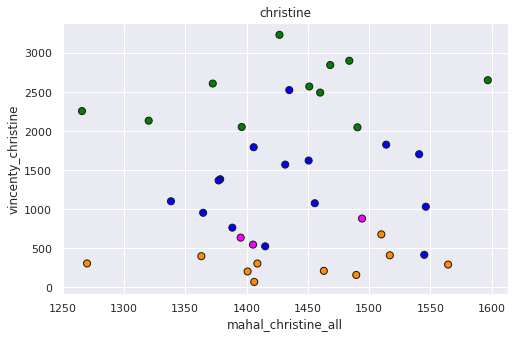

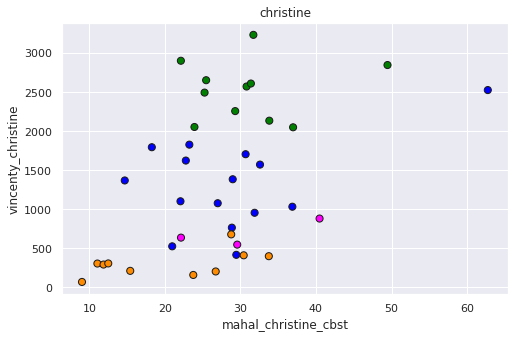

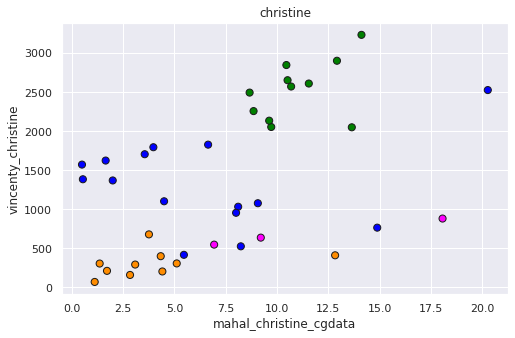

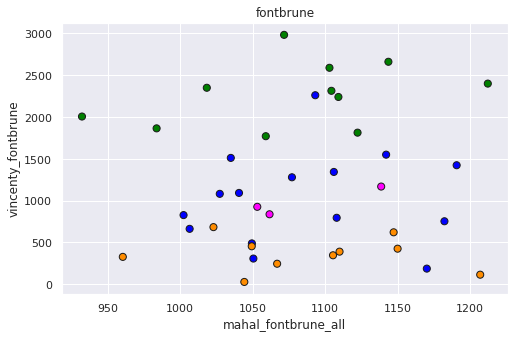

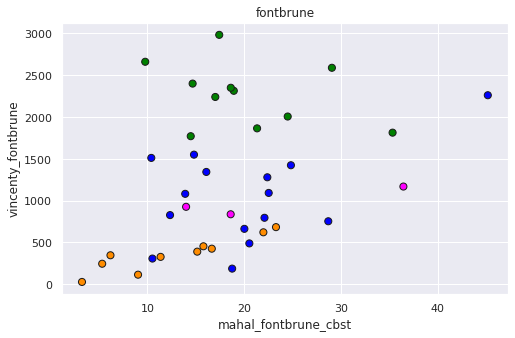

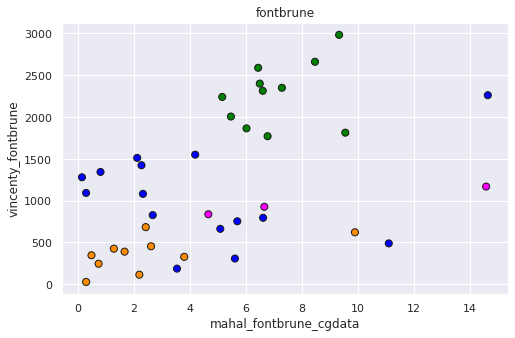

combined


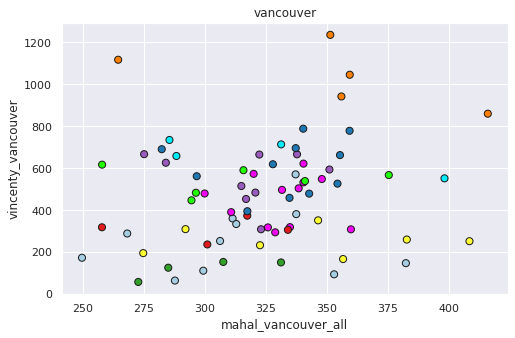

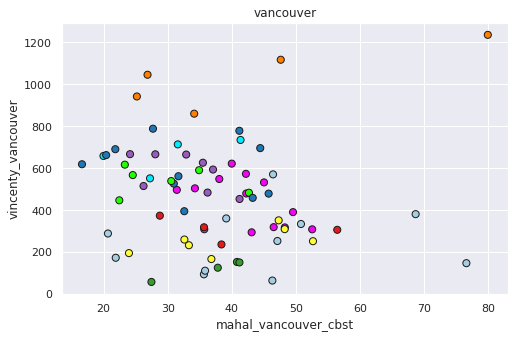

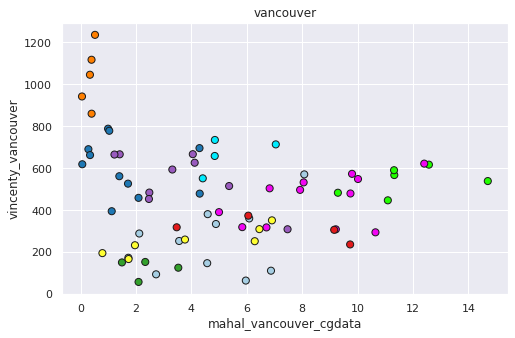

fdc


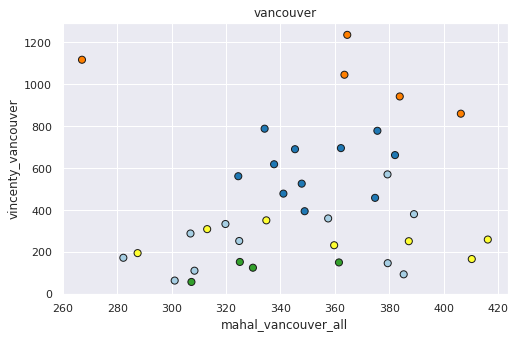

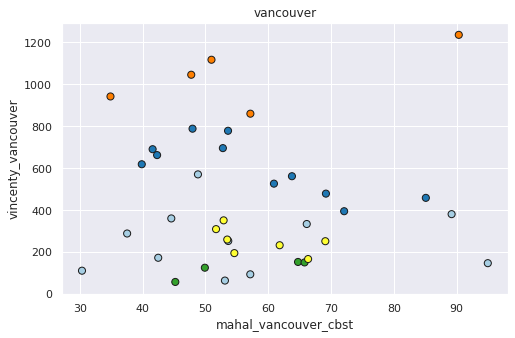

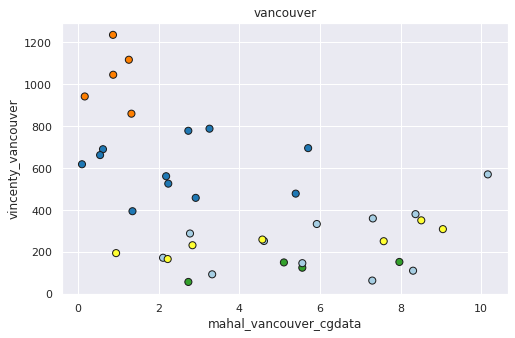

fdi


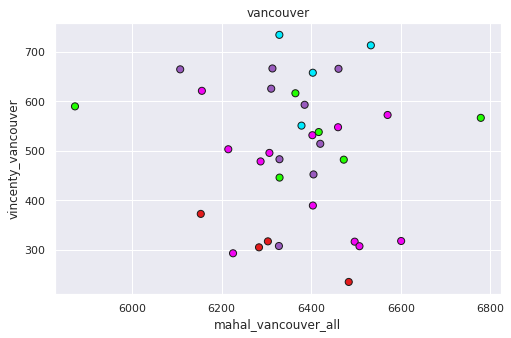

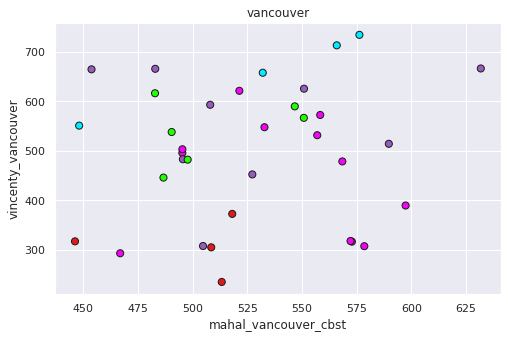

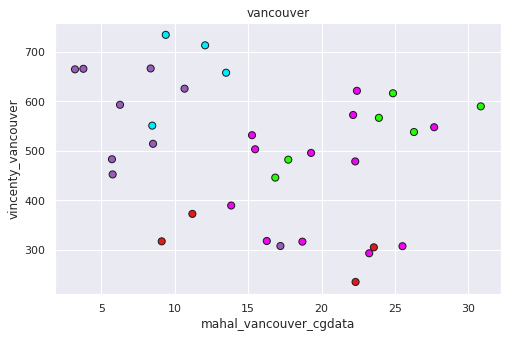

eastern


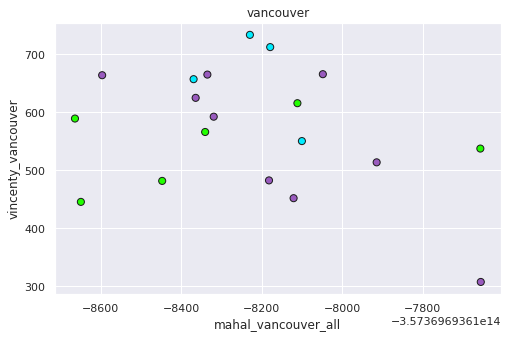

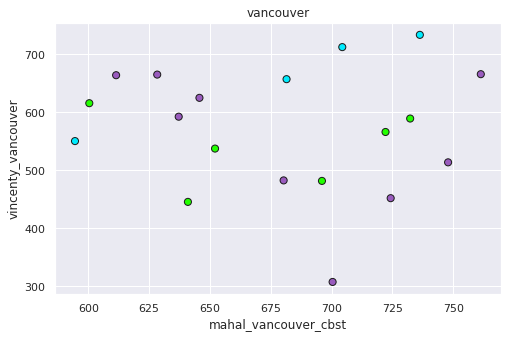

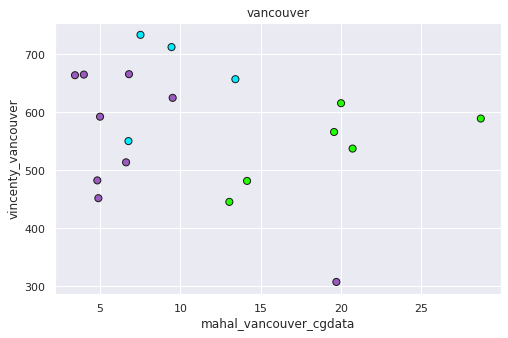

western


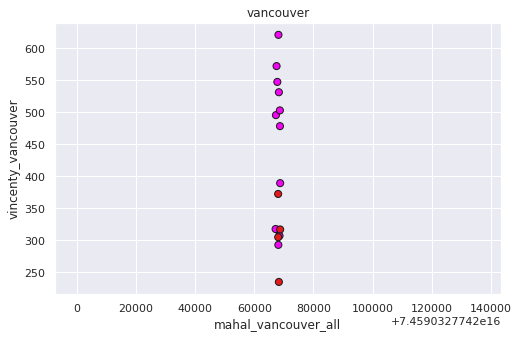

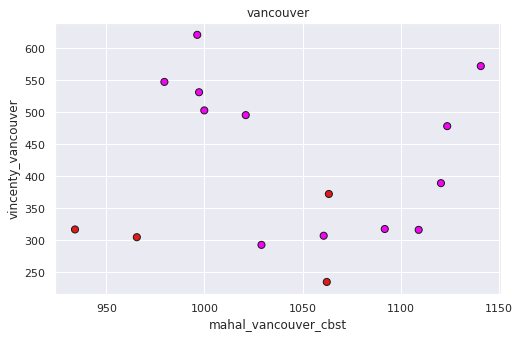

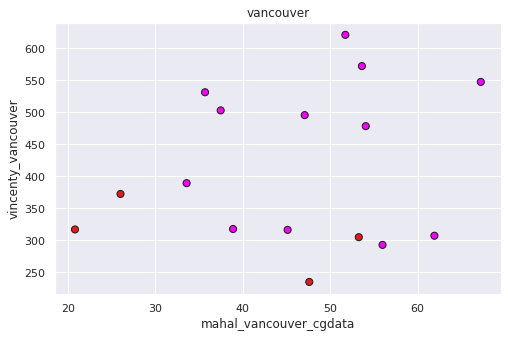

In [27]:
# calculate distances, plot relationship between mahal and vincenty
gpscols = ['LAT', 'LONG']
for spp,df in envdata.items():
    plotcolors = [cdict[pop] for pop in df.index]
    
    for garden in cgdict[spp]:
        
        # CLIMATE DISTANCE
        # ----------------
        
        # 1. mahalanobis - all env variables
        mahalcol = f'mahal_{garden}_all'
        df[mahalcol] = mahalanobis(x=df[envs],
                                   data=df[envs],
                                   center=cgdata.loc[garden, envs])
        # 2. climate-based seed transfer
        mahalcol = f'mahal_{garden}_cbst'
        df[mahalcol] = mahalanobis(x=df[cvars['cbst']],
                                   data=df[cvars['cbst']],
                                   center=cgdata.loc[garden, cvars['cbst']]
                                  )
        
        # 3. garden envs
        myenvs = cvars['doug_prov'] if spp != 'jp' else cvars['jack_prov']
        mahalcol = f'mahal_{garden}_cgdata'
        df[mahalcol] = mahalanobis(x=df[myenvs],
                                   data=df[myenvs],
                                   center=cgdata.loc[garden, myenvs]
                                  )
        
        # GEOGRAPHIC DISTANCE
        # -------------------

        # vincenty (geographic distance)
        vincol = f'vincenty_{garden}'
        df[vincol] = df[gpscols].apply(
            lambda latlong: vincenty(latlong, cgdata.loc[garden, gpscols]), axis=1
        )

for spp,df in envdata.items():
    print(ColorText(spp).bold().blue())
    plotcolors = [cdict[pop] for pop in df.index]
    for garden in cgdict[spp]:
        mahalcols = [col for col in df.columns if 'mahal' in col and garden in col]
        vincol = f'vincenty_{garden}'
        for mahalcol in mahalcols:
            df.plot.scatter(mahalcol, vincol, c=plotcolors, edgecolor='k', s=50)
            plt.title(garden)
            plt.show()

# compare all mahal distances

jp


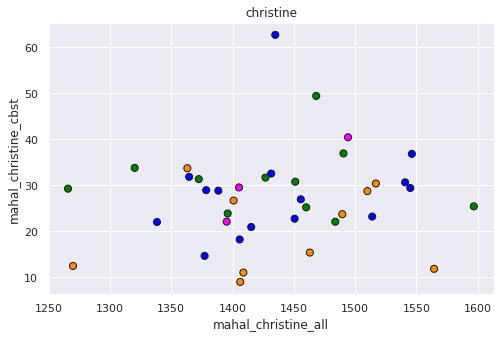

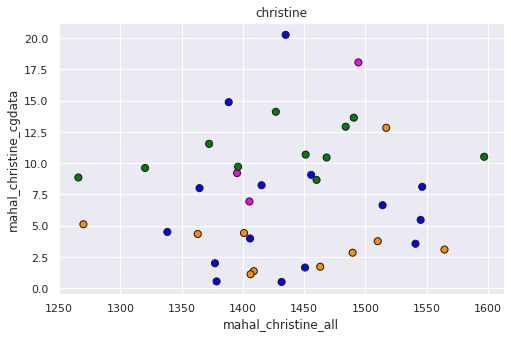

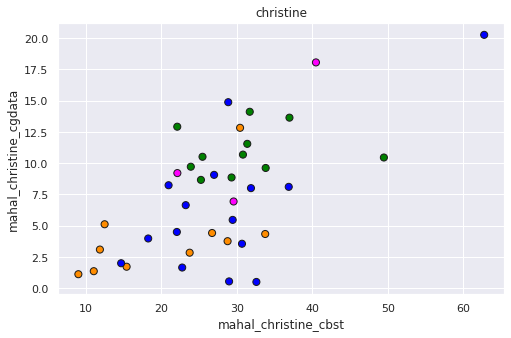

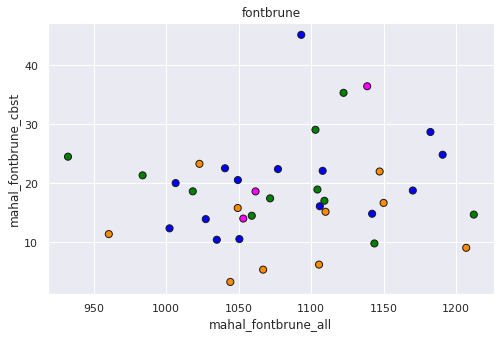

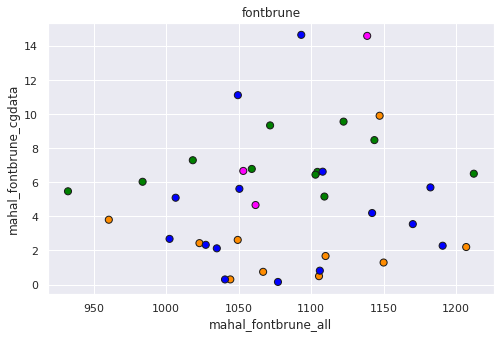

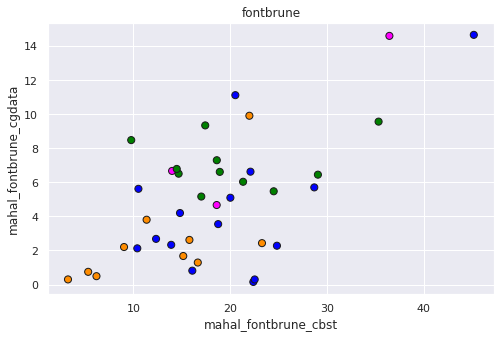

combined


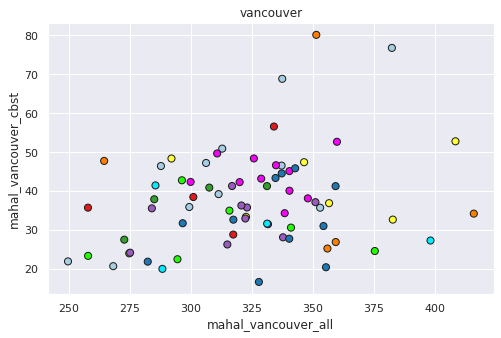

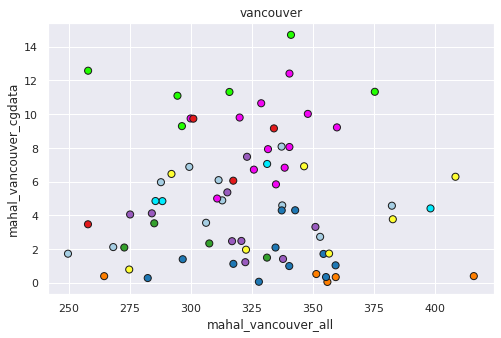

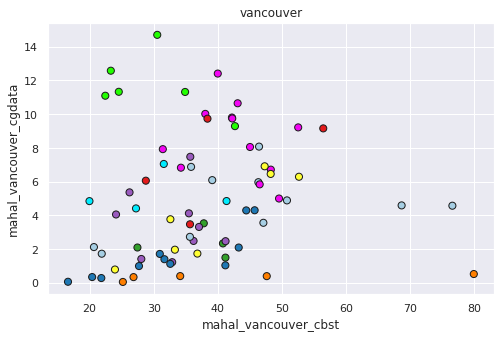

fdc


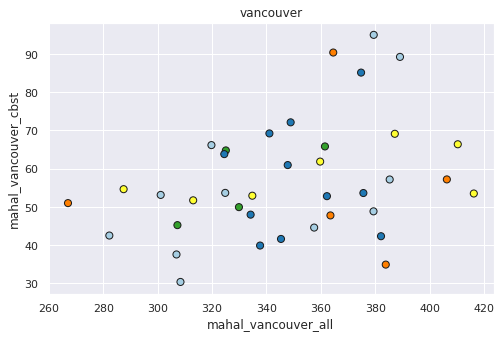

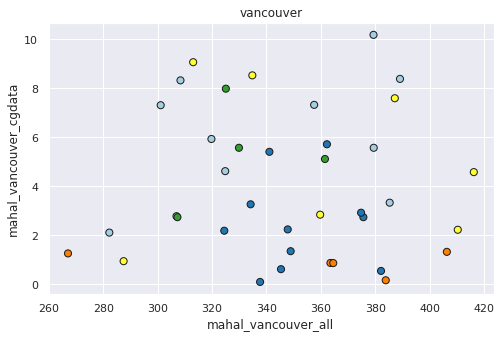

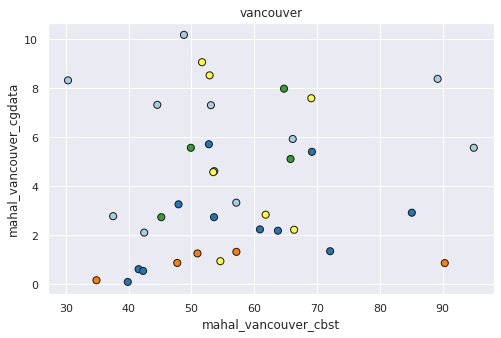

fdi


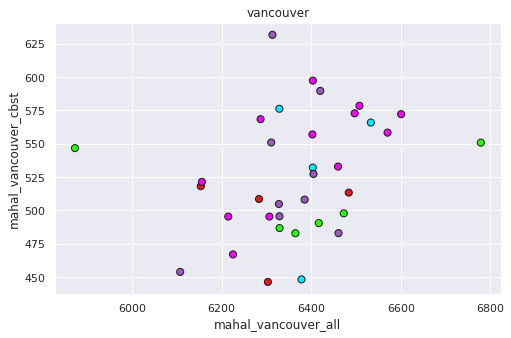

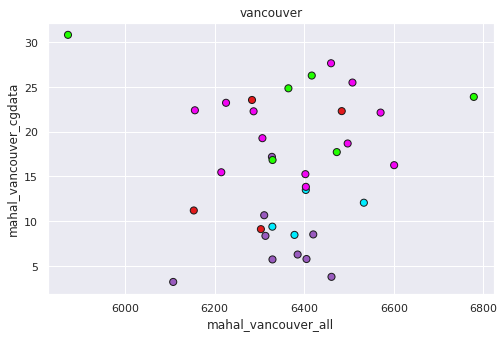

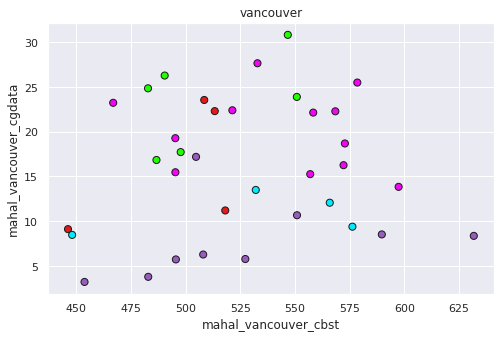

eastern


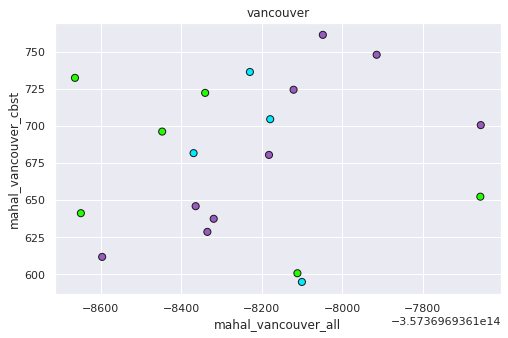

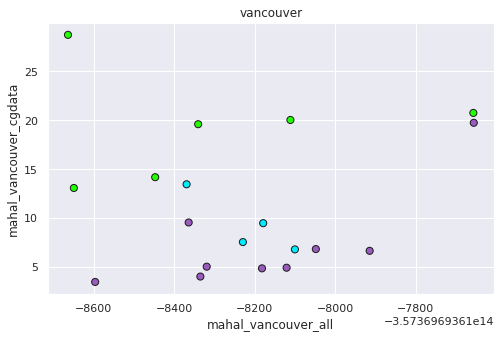

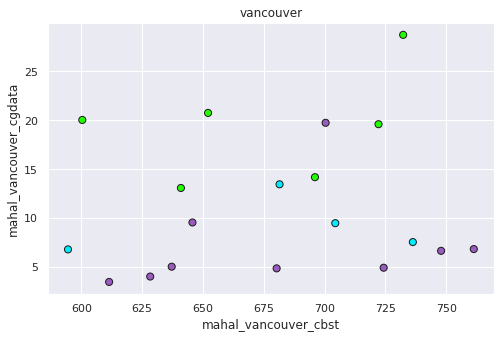

western


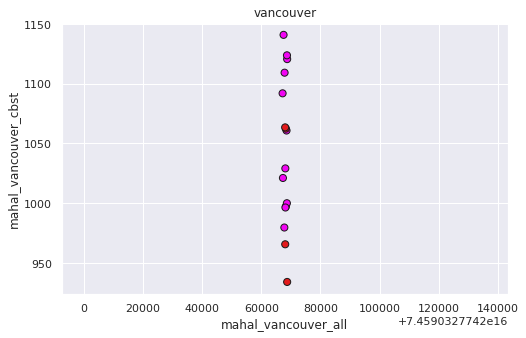

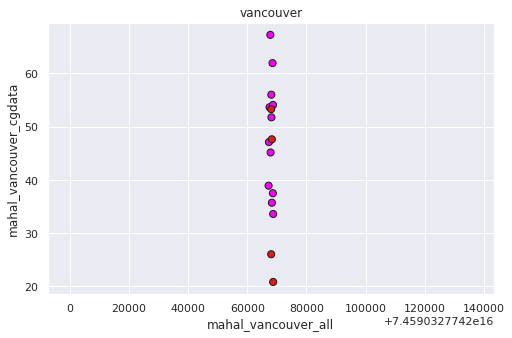

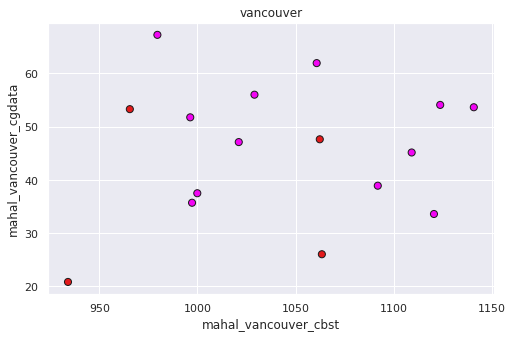

In [28]:
for spp,df in envdata.items():
    print(ColorText(spp).bold().blue())
    plotcolors = [cdict[pop] for pop in df.index]
    for garden in cgdict[spp]:
        mahalcols = [col for col in df.columns if 'mahal' in col and garden in col]
        for i,mahalcol_i in enumerate(mahalcols):
            for j,mahalcol_j in enumerate(mahalcols):
                if i < j:
                    df.plot.scatter(mahalcol_i, mahalcol_j, c=plotcolors, edgecolor='k', s=50)
                    plt.title(garden)
                    plt.show()

<a id='compare'></a>
# 4. compare distances to phenotypes

In [29]:
# # unnecessary after updating phenos in Nov 2021
# exclude_phenos = ['Blup_lm_slope_corrected',
#                   'Blup_beta_inflec_correc_before',
#                   ' Blup_Tem4_corrected_fv_fm',
#                   ' Blup_Tem3_corrected_fv_fm',
#                   'Blup_h_max_dry',
#                   'Blup_h_increment_total_wet']

In [30]:
def calc_rmse(obs, pred, kind=None):
    """Calculate (+/- normalized) root mean squared error.
    
    if kind is None : return unnormalized RMSE
    if kind == 'mean' : normalize by mean obs
    if kind == 'quantile' : normalize by interquartile range
    """
    goodvals = np.logical_and(obs.notnull(), pred.notnull())
    obs = obs.loc[goodvals]
    pred = pred.loc[goodvals]
    
    rmse = np.sqrt((
        (obs - pred)**2).mean()
    )
    if kind == 'mean':
        rmse /= np.mean(obs)
    elif kind == 'quantile':
        rmse /= (np.quantile(obs, 0.75) - np.quantile(obs, 0.25))
    return round(rmse, 4)

jp fontbrune Mortality_2018 mahal_fontbrune_all


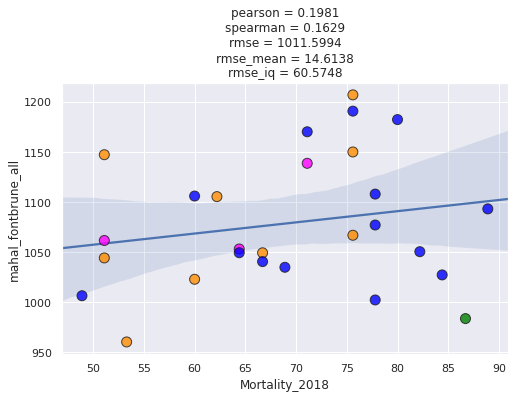

jp fontbrune Mortality_2018 mahal_fontbrune_cbst


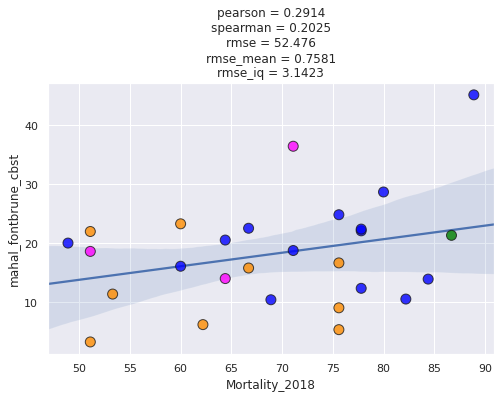

jp fontbrune Mortality_2018 mahal_fontbrune_cgdata


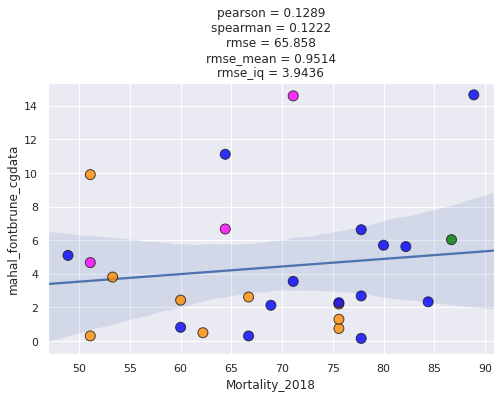

jp fontbrune Mortality_2018 vincenty_fontbrune


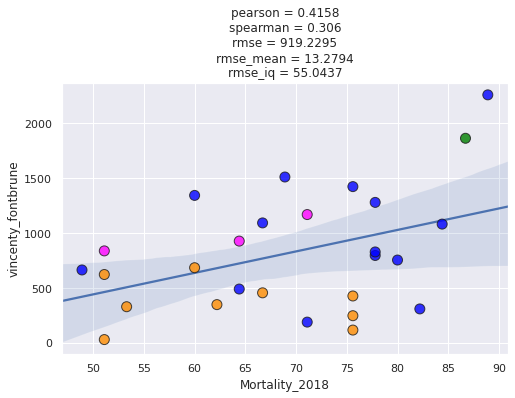

jp fontbrune Mean_Height_2018 mahal_fontbrune_all


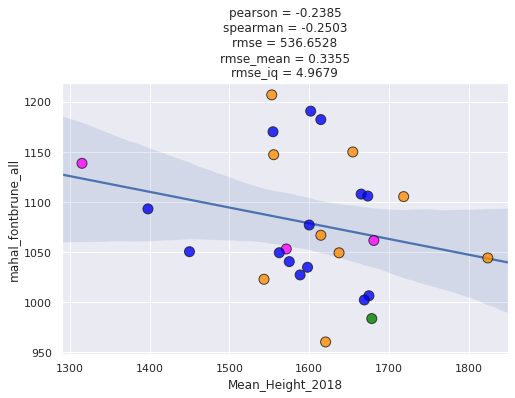

jp fontbrune Mean_Height_2018 mahal_fontbrune_cbst


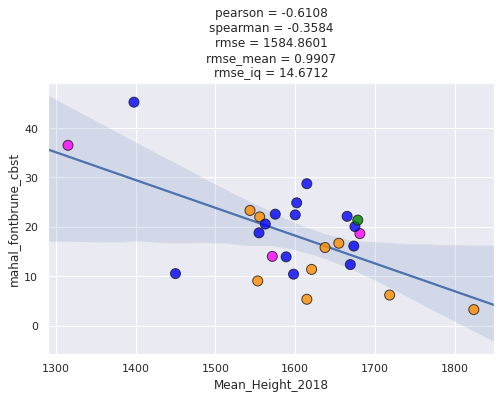

jp fontbrune Mean_Height_2018 mahal_fontbrune_cgdata


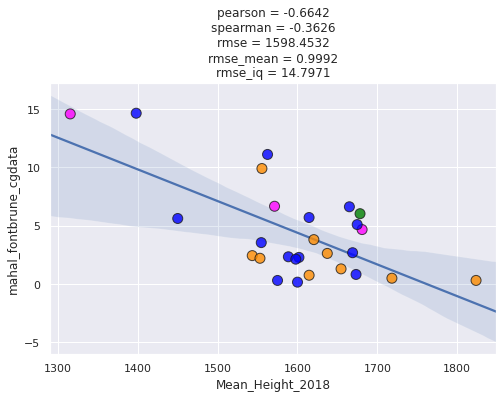

jp fontbrune Mean_Height_2018 vincenty_fontbrune


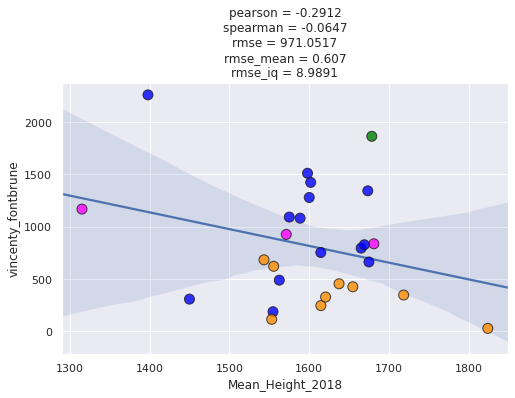

jp fontbrune Mean_DBH2018 mahal_fontbrune_all


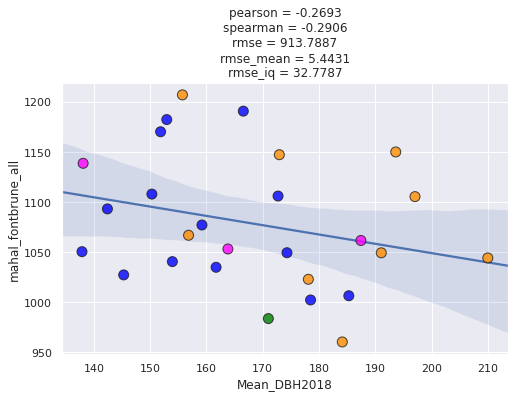

jp fontbrune Mean_DBH2018 mahal_fontbrune_cbst


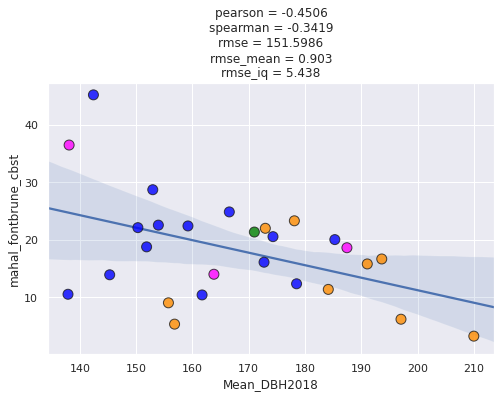

jp fontbrune Mean_DBH2018 mahal_fontbrune_cgdata


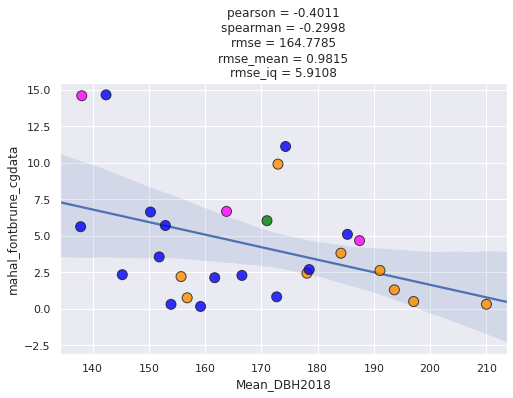

jp fontbrune Mean_DBH2018 vincenty_fontbrune


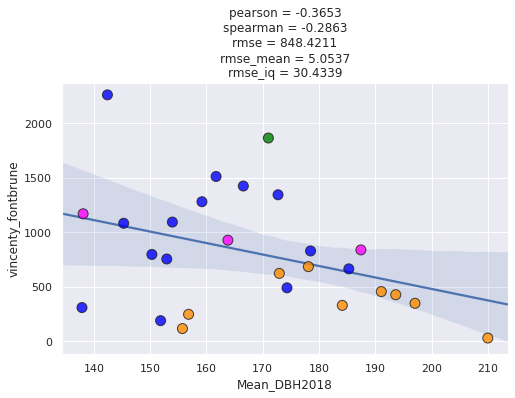

jp christine Mortality_2018 mahal_christine_all


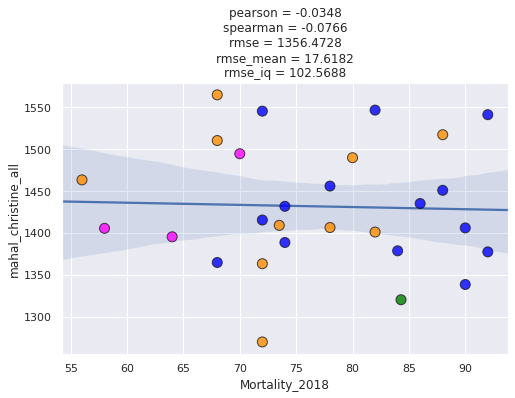

jp christine Mortality_2018 mahal_christine_cbst


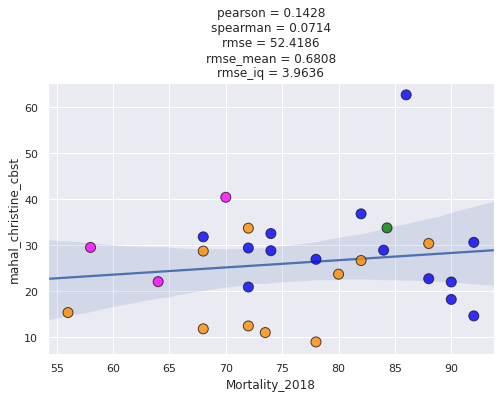

jp christine Mortality_2018 mahal_christine_cgdata


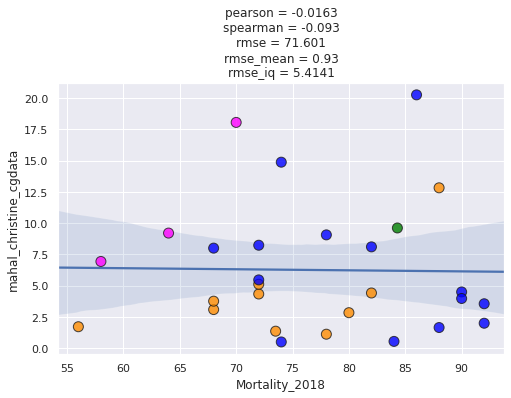

jp christine Mortality_2018 vincenty_christine


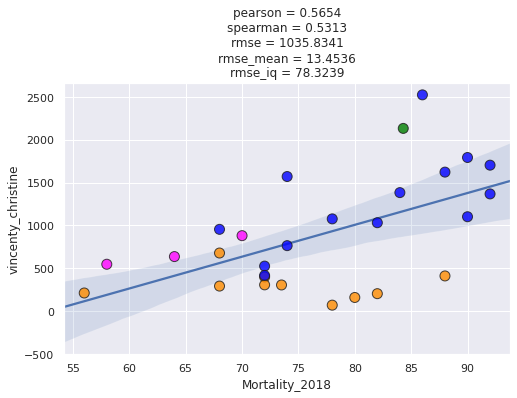

jp christine Mean_Height_2018 mahal_christine_all


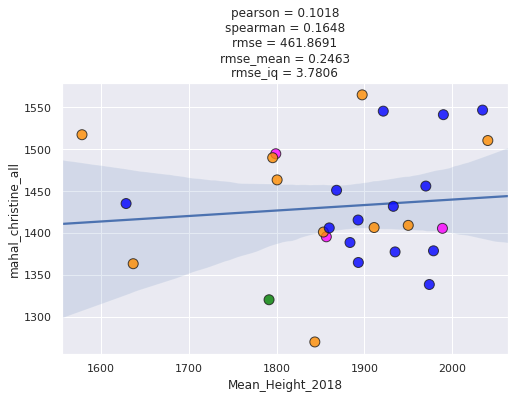

jp christine Mean_Height_2018 mahal_christine_cbst


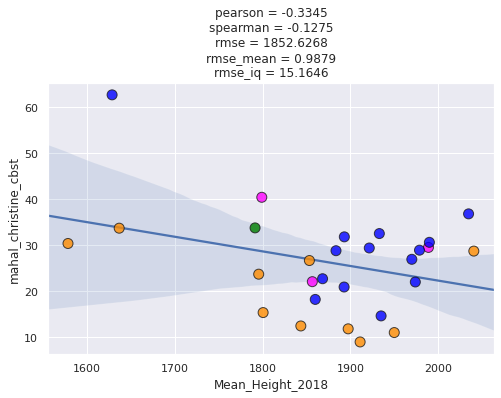

jp christine Mean_Height_2018 mahal_christine_cgdata


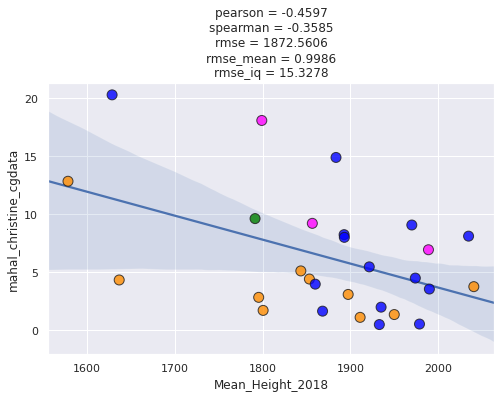

jp christine Mean_Height_2018 vincenty_christine


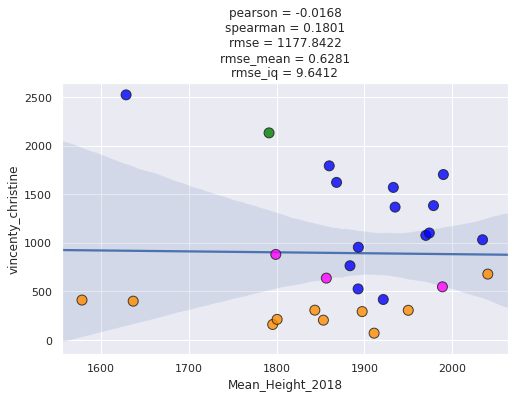

jp christine Mean_DBH2018 mahal_christine_all


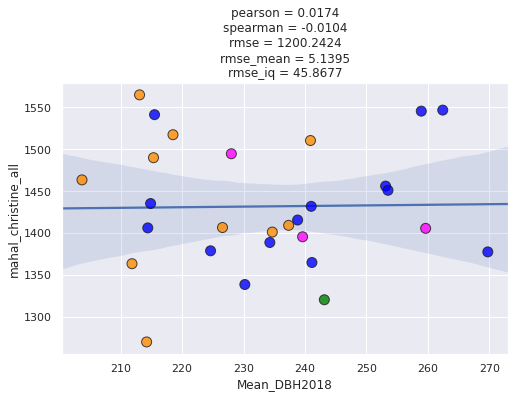

jp christine Mean_DBH2018 mahal_christine_cbst


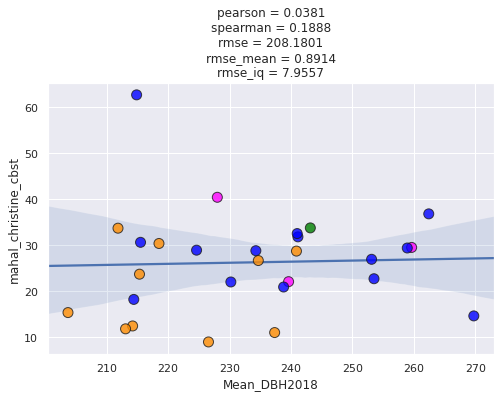

jp christine Mean_DBH2018 mahal_christine_cgdata


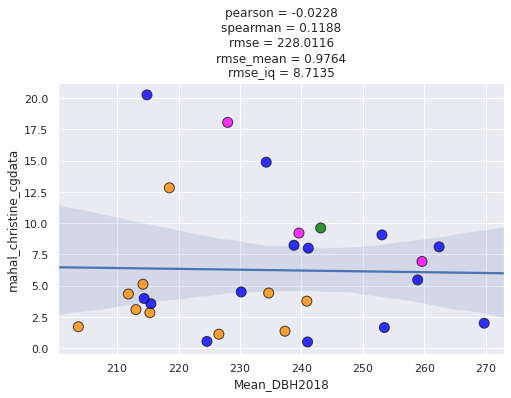

jp christine Mean_DBH2018 vincenty_christine


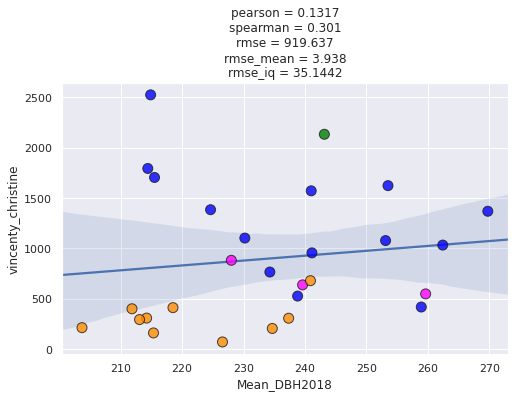

fdi vancouver blup_increment mahal_vancouver_all


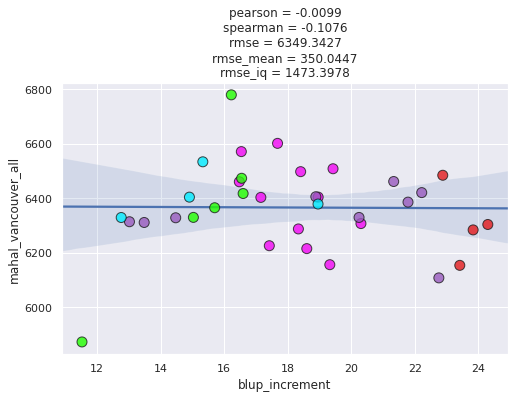

fdi vancouver blup_increment mahal_vancouver_cbst


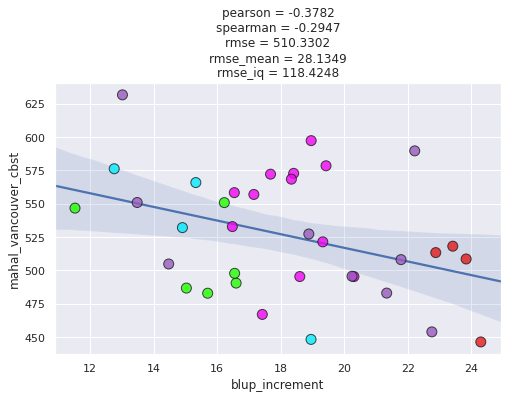

fdi vancouver blup_increment mahal_vancouver_cgdata


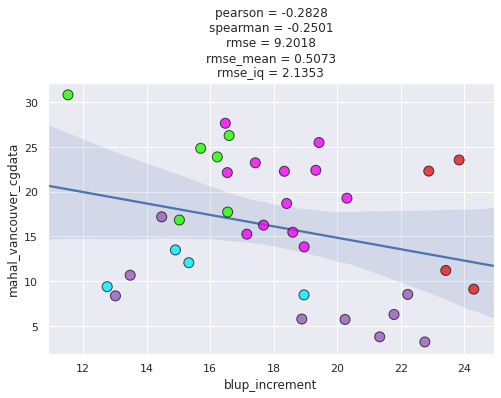

fdi vancouver blup_increment vincenty_vancouver


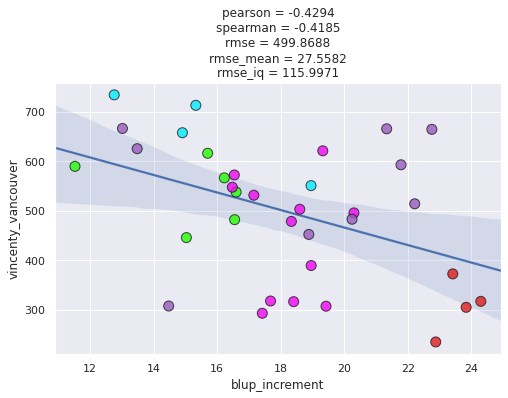

fdi vancouver blup_shoot_biomass mahal_vancouver_all


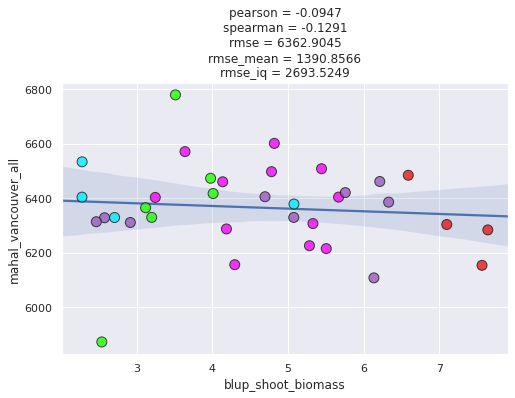

fdi vancouver blup_shoot_biomass mahal_vancouver_cbst


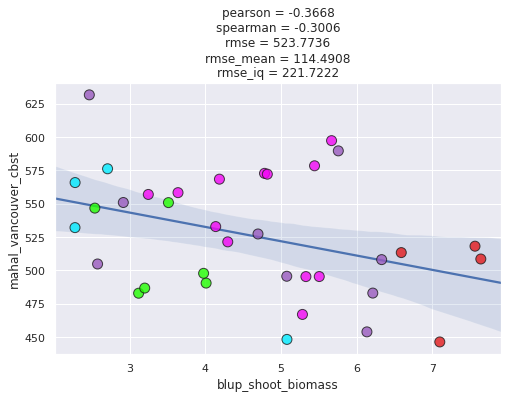

fdi vancouver blup_shoot_biomass mahal_vancouver_cgdata


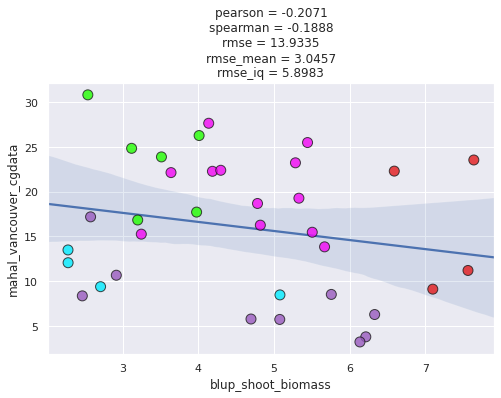

fdi vancouver blup_shoot_biomass vincenty_vancouver


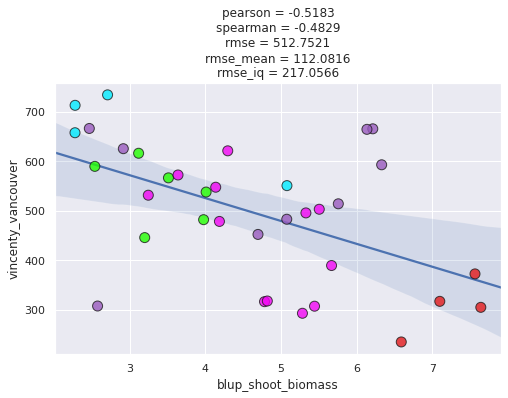

fdc vancouver blup_increment mahal_vancouver_all


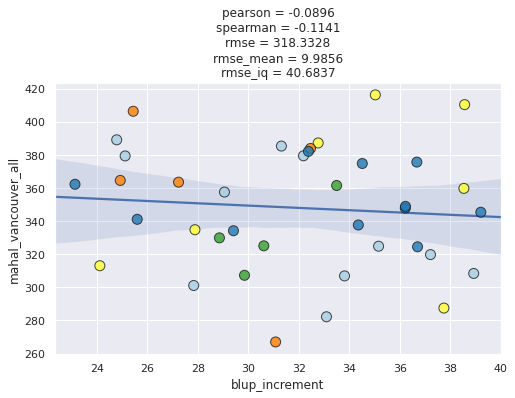

fdc vancouver blup_increment mahal_vancouver_cbst


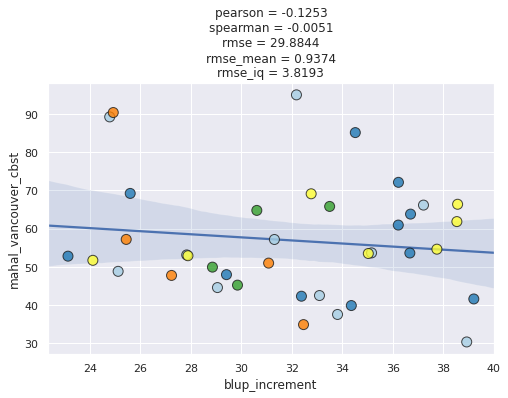

fdc vancouver blup_increment mahal_vancouver_cgdata


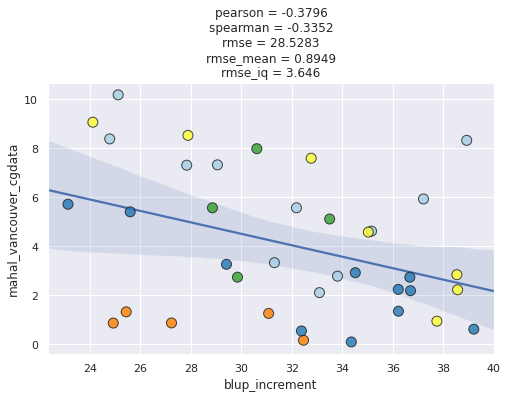

fdc vancouver blup_increment vincenty_vancouver


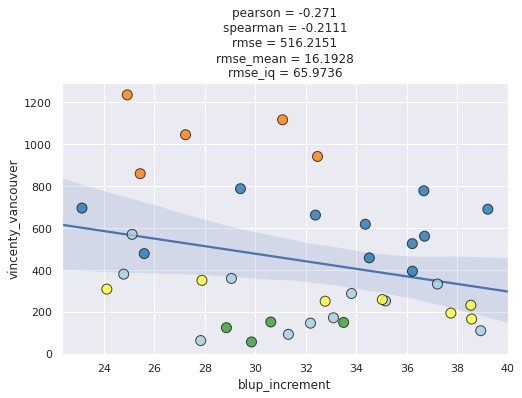

fdc vancouver blup_shoot_biomass mahal_vancouver_all


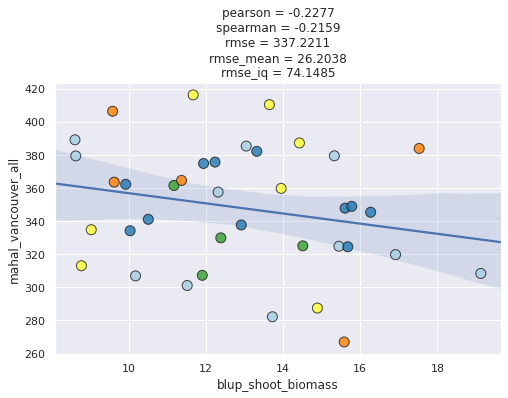

fdc vancouver blup_shoot_biomass mahal_vancouver_cbst


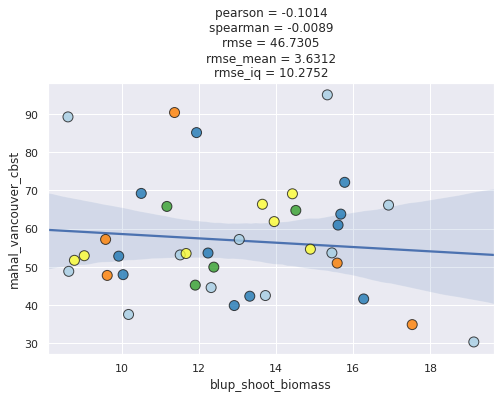

fdc vancouver blup_shoot_biomass mahal_vancouver_cgdata


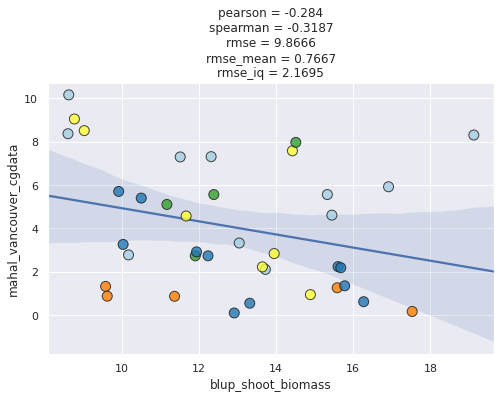

fdc vancouver blup_shoot_biomass vincenty_vancouver


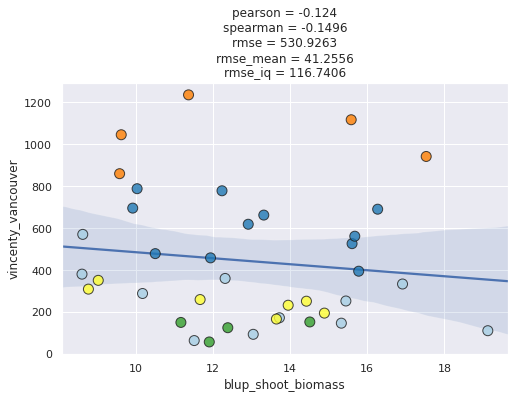

combined vancouver blup_increment mahal_vancouver_all


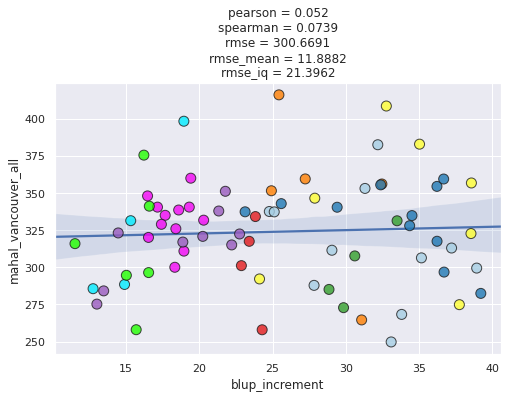

combined vancouver blup_increment mahal_vancouver_cbst


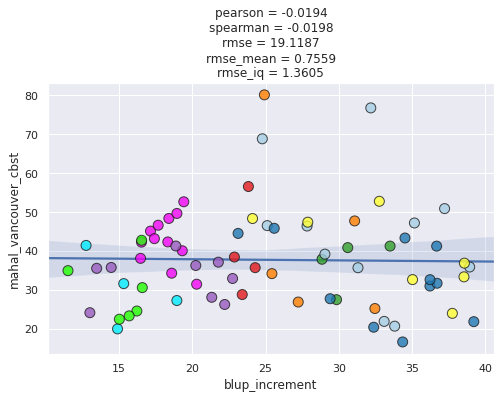

combined vancouver blup_increment mahal_vancouver_cgdata


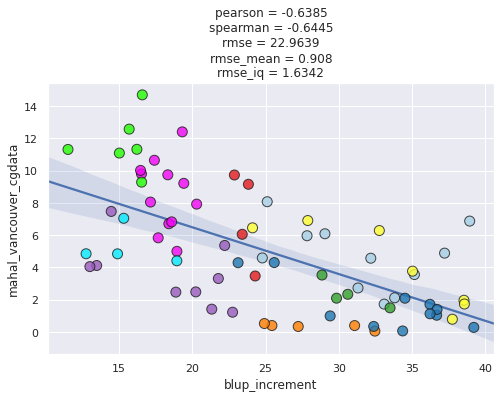

combined vancouver blup_increment vincenty_vancouver


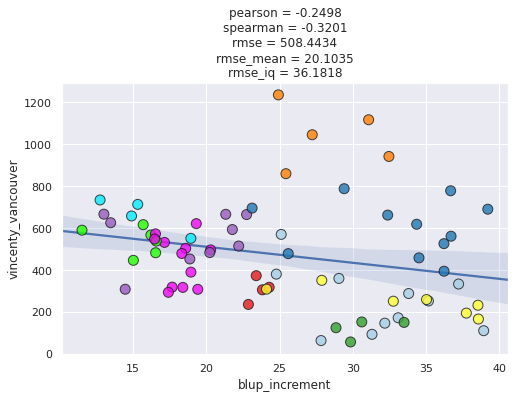

combined vancouver blup_shoot_biomass mahal_vancouver_all


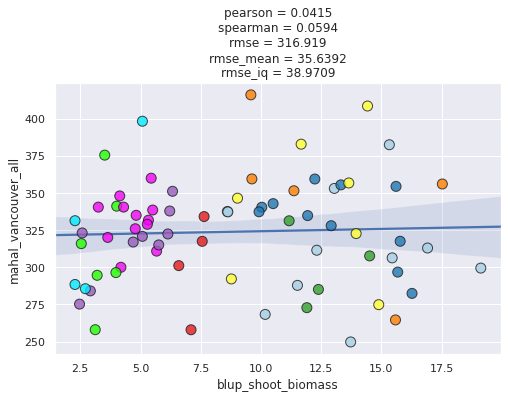

combined vancouver blup_shoot_biomass mahal_vancouver_cbst


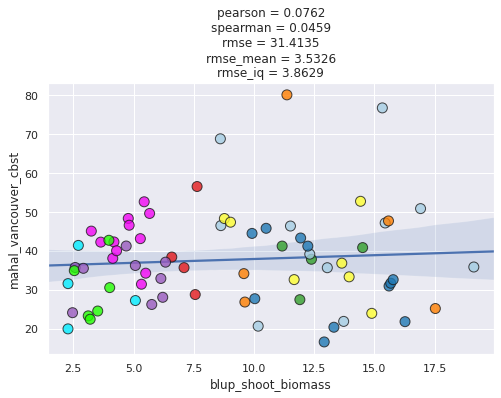

combined vancouver blup_shoot_biomass mahal_vancouver_cgdata


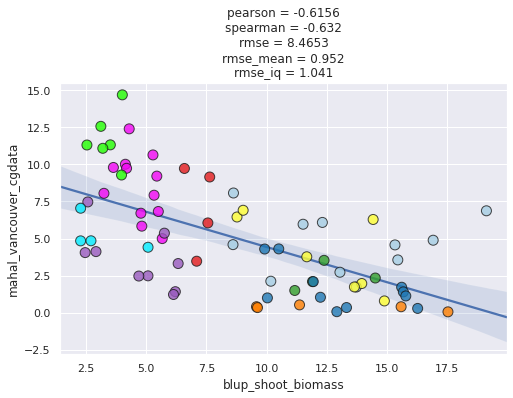

combined vancouver blup_shoot_biomass vincenty_vancouver


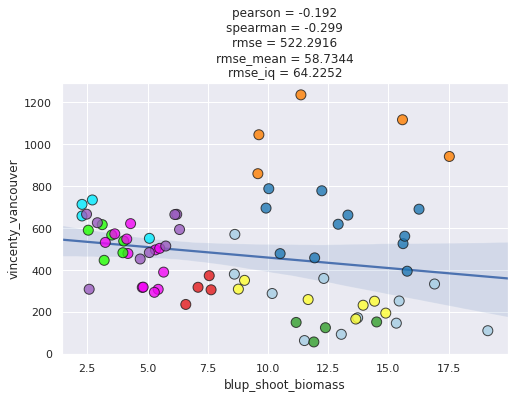

eastern vancouver blup_increment mahal_vancouver_all


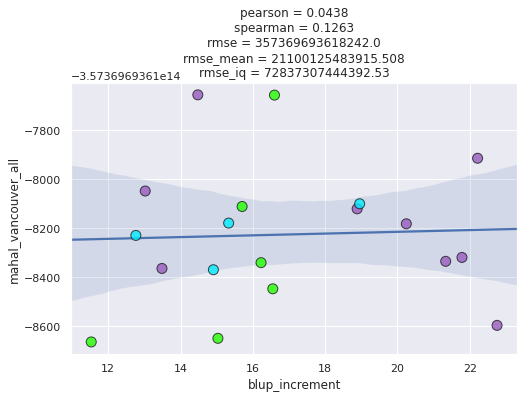

eastern vancouver blup_increment mahal_vancouver_cbst


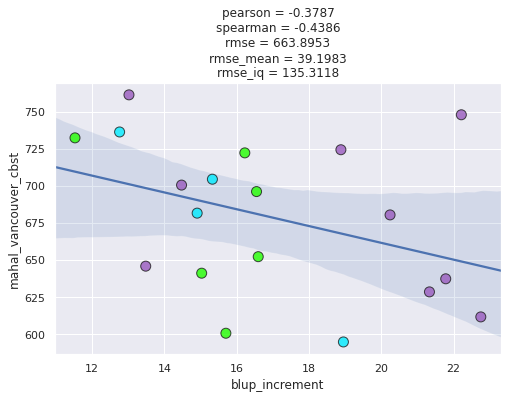

eastern vancouver blup_increment mahal_vancouver_cgdata


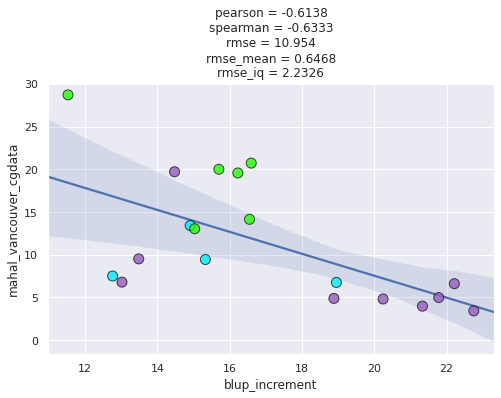

eastern vancouver blup_increment vincenty_vancouver


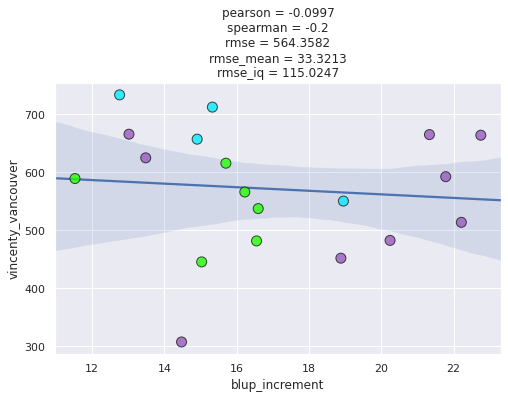

eastern vancouver blup_shoot_biomass mahal_vancouver_all


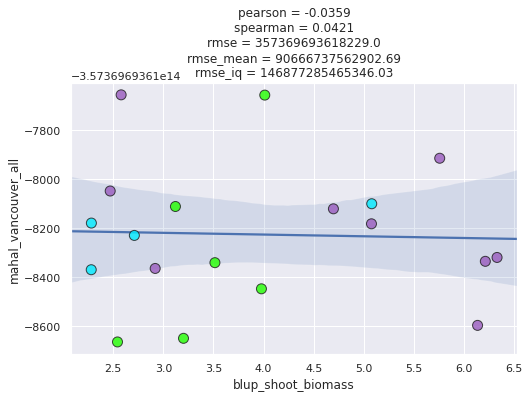

eastern vancouver blup_shoot_biomass mahal_vancouver_cbst


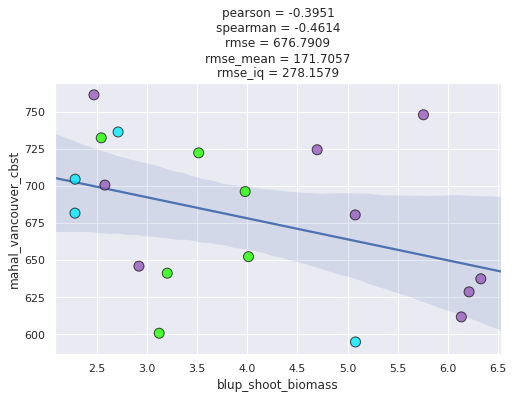

eastern vancouver blup_shoot_biomass mahal_vancouver_cgdata


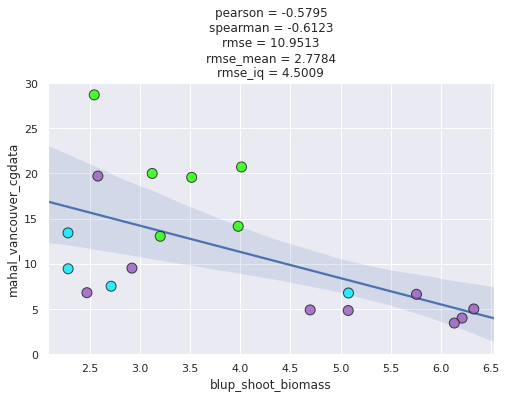

eastern vancouver blup_shoot_biomass vincenty_vancouver


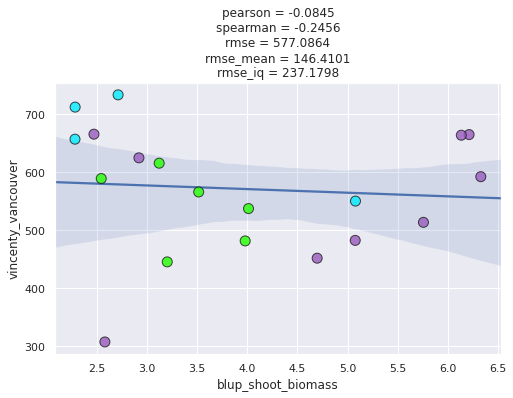

western vancouver blup_increment mahal_vancouver_all


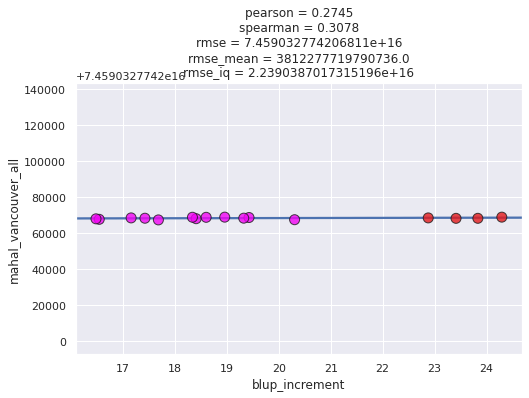

western vancouver blup_increment mahal_vancouver_cbst


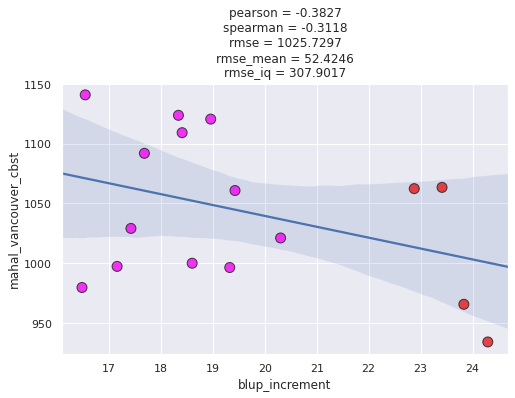

western vancouver blup_increment mahal_vancouver_cgdata


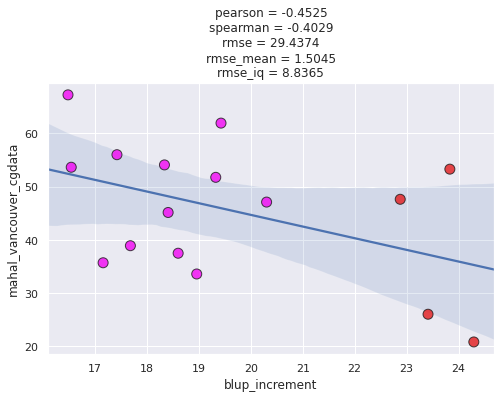

western vancouver blup_increment vincenty_vancouver


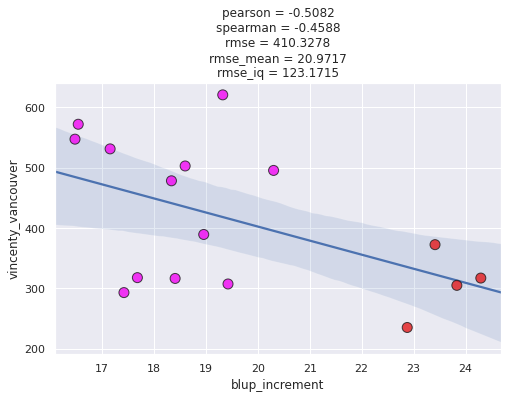

western vancouver blup_shoot_biomass mahal_vancouver_all


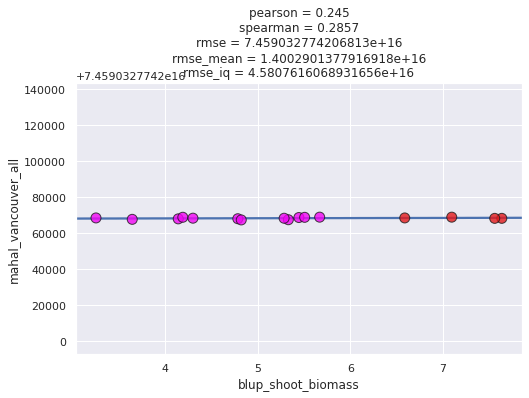

western vancouver blup_shoot_biomass mahal_vancouver_cbst


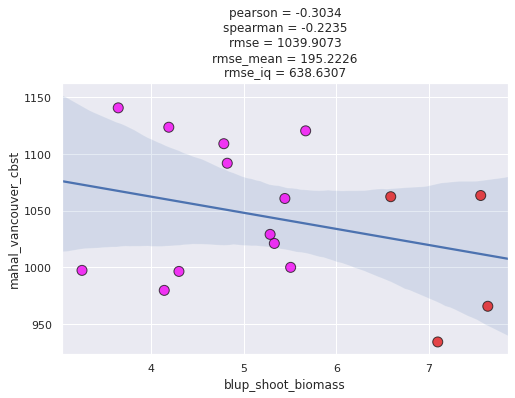

western vancouver blup_shoot_biomass mahal_vancouver_cgdata


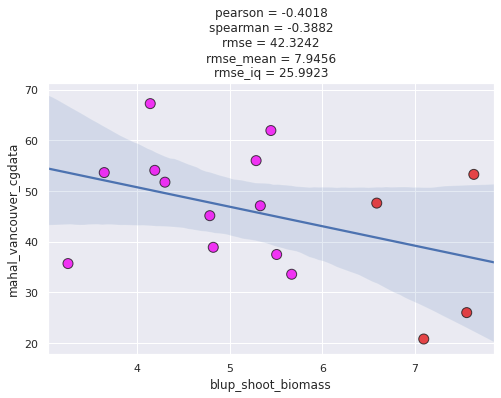

western vancouver blup_shoot_biomass vincenty_vancouver


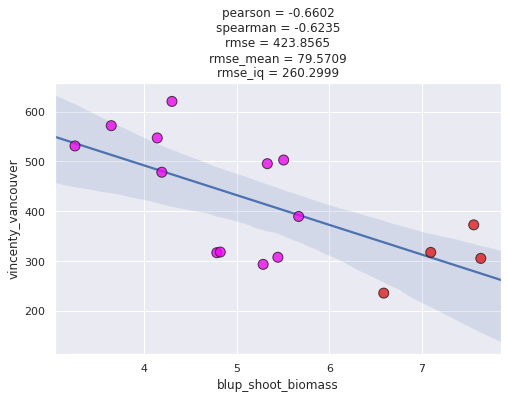

spp     garden               pheno         distance_metric  spearman  \
0        jp  fontbrune      Mortality_2018     mahal_fontbrune_all    0.1629   
1        jp  fontbrune      Mortality_2018    mahal_fontbrune_cbst    0.2025   
2        jp  fontbrune      Mortality_2018  mahal_fontbrune_cgdata    0.1222   
3        jp  fontbrune      Mortality_2018      vincenty_fontbrune    0.3060   
4        jp  fontbrune    Mean_Height_2018     mahal_fontbrune_all   -0.2503   
..      ...        ...                 ...                     ...       ...   
59  western  vancouver      blup_increment      vincenty_vancouver   -0.4588   
60  western  vancouver  blup_shoot_biomass     mahal_vancouver_all    0.2857   
61  western  vancouver  blup_shoot_biomass    mahal_vancouver_cbst   -0.2235   
62  western  vancouver  blup_shoot_biomass  mahal_vancouver_cgdata   -0.3882   
63  western  vancouver  blup_shoot_biomass      vincenty_vancouver   -0.6235   

    pearson          rmse     rmse_mean       rmse_iq  
0    0.1981  1.011599e+03  1.461380e+01  6.057480e+01  
1    0.2914  5.247600e+01  7.581000e-01  3.142300e+00  
2    0.1289  6.585800e+01  9.514000e-01  3.943600e+00  
3    0.4158  9.192295e+02  1.327940e+01  5.504370e+01  
4   -0.2385  5.366528e+02  3.355000e-01  4.967900e+00  
..      ...           ...           ...           ...  
59  -0.5082  4.103278e+02  2.097170e+01  1.231715e+02  
60   0.2450  7.459033e+16  1.400290e+16  4.580762e+16  
61  -0.3034  1.039907e+03  1.952226e+02  6.386307e+02  
62  -0.4018  4.232420e+01  7.945600e+00  2.599230e+01  
63  -0.6602  4.238565e+02  7.957090e+01  2.602999e+02  

[64 rows x 9 columns]

In [31]:
cordf = pd.DataFrame(
    columns = ['spp', 'garden', 'pheno', 'distance_metric', 'spearman', 'pearson', 'rmse', 'rmse_mean', 'rmse_iq']
)
for spp,phenodict in phenodata.items():
    for garden,phenodf in phenodict.items():
        envdf = envdata[spp].loc[phenodf.index]
        for pheno in phenodf.columns:
#             if pheno in exclude_phenos:  # unnecessary after updating phenos in Nov 2021
#                 continue
            plotcolors = [cdict[pop] for pop in phenodf.index]
            distancecols = [col for col in envdf.columns if garden in col]
            for distcol in distancecols:
                print(ColorText(f'{spp} {garden} {pheno} {distcol}').bold())
                sns.regplot(x=phenodf[pheno],
                            y=envdf[distcol],
                            truncate=False,
                            scatter_kws={'color' : plotcolors,
                                         'zorder' : 5,
                                         'edgecolor' : 'k',
                                         's' : 100})
                r = round(phenodf[pheno].corr(envdf[distcol], method='pearson'), 4)
                rho = round(phenodf[pheno].corr(envdf[distcol], method='spearman'), 4)
                rmse = calc_rmse(phenodf[pheno], envdf[distcol])
                rmse_mean = calc_rmse(phenodf[pheno], envdf[distcol], kind='mean')
                rmse_iq = calc_rmse(phenodf[pheno], envdf[distcol], kind='quantile')
                plt.title(f'pearson = {r}\nspearman = {rho}\n{rmse = }\n{rmse_mean = }\n{rmse_iq = }')
                plt.show()
                cordf.loc[nrow(cordf)] = [spp, garden, pheno, distcol, rho, r, rmse, rmse_mean, rmse_iq]
cordf

In [32]:
# save
resdir = makedir('/data/projects/pool_seq/phenotypic_data/offset_misc_files/results/climate_geo_dist')

# save distances
pkl = op.join(resdir, 'pop_distances.pkl')
pkldump(envdata, pkl)

# save correlations
resfile = op.join(resdir, 'climate_geo_dist.txt')
cordf.to_csv(resfile, sep='\t', index=False)
resfile

'/data/projects/pool_seq/phenotypic_data/offset_misc_files/results/climate_geo_dist/climate_geo_dist.txt'

In [33]:
# time to complete notebook
formatclock(dt.now() - t1, exact=True)

'0-00:00:29'